# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

## Caveats:

- The confirmed cases reported by each country are different from the number of infected people in each country.


- **The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infected people.** For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but the actual cases may not be rising as the same rate.


- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.


- The growth rate (or recent doubling time) changes with time, and will eventually fall to zero. So be cautious about extrapolating trends into the future based on current growth rates. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/16/20


,3/16/20
Country/Region,
China,81033
Italy,27980
Iran,14991
Spain,9942
"Korea, South",8236
Germany,7272
France,6650
US,4632
Switzerland,2200


## Curve Fitting Global COVID-19 Cases

In [4]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 81033
	Confirmed cases on 3/9/20 	 80860
	Ratio: 1.0
	Weekly increase: 0.2 %
	Daily increase: 0.0 % per day
	Doubling Time (represents recent growth): 2270.3 days

** Based on Logistic Fit**

	R^2: 0.995119432392
	Doubling Time (during middle of growth):  6.46 (± 0.57 ) days


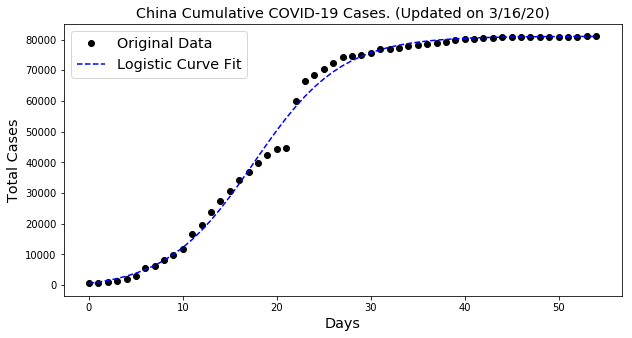



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 27980
	Confirmed cases on 3/9/20 	 9172
	Ratio: 3.05
	Weekly increase: 205.1 %
	Daily increase: 17.3 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Logistic Fit**

	R^2: 0.996900158138
	Doubling Time (during middle of growth):  6.73 (± 0.69 ) days

** Based on Exponential Fit **

	R^2: 0.995937593765
	Doubling Time (represents overall growth):  3.9 (± 0.16 ) days


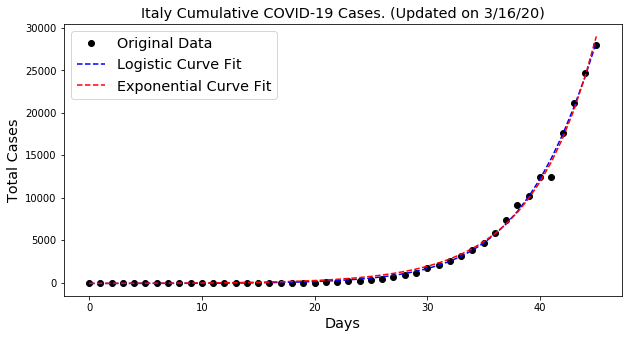



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 14991
	Confirmed cases on 3/9/20 	 7161
	Ratio: 2.09
	Weekly increase: 109.3 %
	Daily increase: 11.1 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.996205231827
	Doubling Time (during middle of growth):  6.31 (± 0.99 ) days


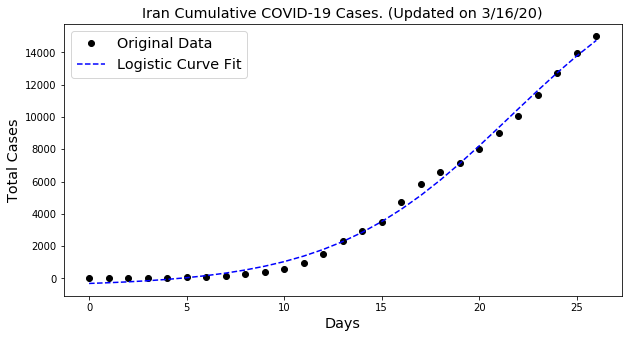



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 9942
	Confirmed cases on 3/9/20 	 1073
	Ratio: 9.27
	Weekly increase: 826.6 %
	Daily increase: 37.4 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Exponential Fit **

	R^2: 0.987698675132
	Doubling Time (represents overall growth):  2.36 (± 0.16 ) days


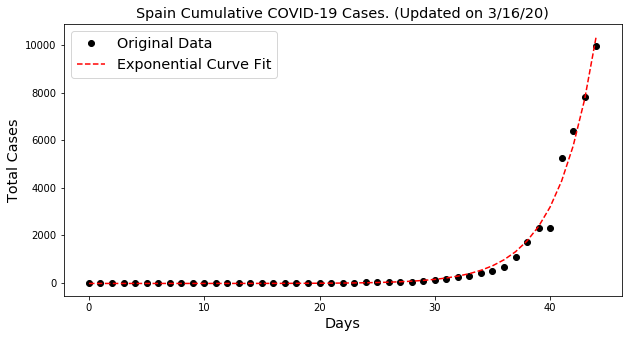



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 8236
	Confirmed cases on 3/9/20 	 7478
	Ratio: 1.1
	Weekly increase: 10.1 %
	Daily increase: 1.4 % per day
	Doubling Time (represents recent growth): 50.3 days

** Based on Logistic Fit**

	R^2: 0.999534075375
	Doubling Time (during middle of growth):  4.06 (± 0.12 ) days


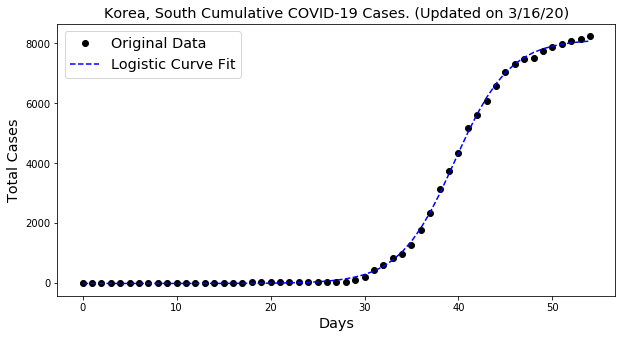



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 7272
	Confirmed cases on 3/9/20 	 1176
	Ratio: 6.18
	Weekly increase: 518.4 %
	Daily increase: 29.7 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Exponential Fit **

	R^2: 0.995596801867
	Doubling Time (represents overall growth):  2.64 (± 0.1 ) days


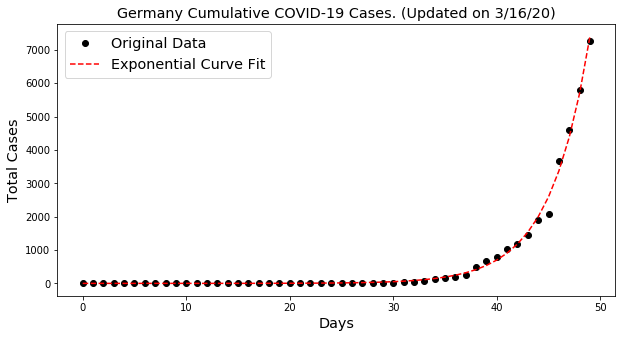



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 6650
	Confirmed cases on 3/9/20 	 1217
	Ratio: 5.46
	Weekly increase: 446.4 %
	Daily increase: 27.5 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.989485588856
	Doubling Time (represents overall growth):  3.09 (± 0.18 ) days


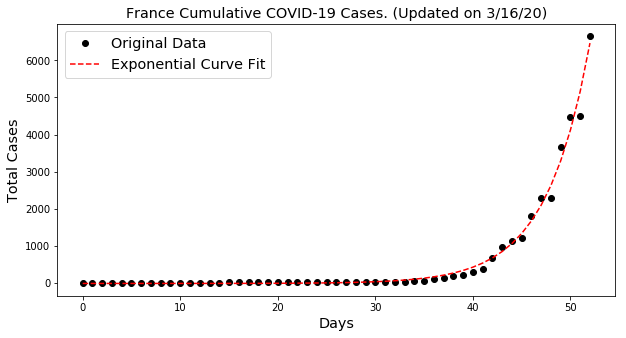



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 4632
	Confirmed cases on 3/9/20 	 583
	Ratio: 7.95
	Weekly increase: 694.5 %
	Daily increase: 34.5 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Exponential Fit **

	R^2: 0.99885000821
	Doubling Time (represents overall growth):  2.59 (± 0.05 ) days


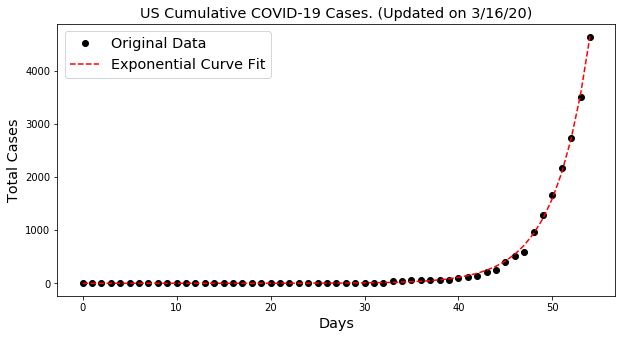



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 2200
	Confirmed cases on 3/9/20 	 374
	Ratio: 5.88
	Weekly increase: 488.2 %
	Daily increase: 28.8 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Logistic Fit**

	R^2: 0.978729572655
	Doubling Time (during middle of growth):  4.13 (± 1.89 ) days

** Based on Exponential Fit **

	R^2: 0.977260259155
	Doubling Time (represents overall growth):  2.74 (± 0.46 ) days


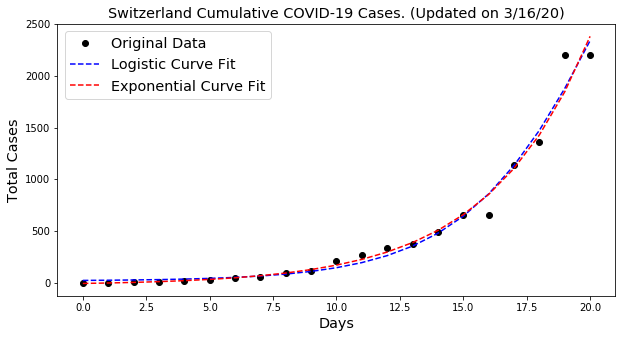



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 1551
	Confirmed cases on 3/9/20 	 322
	Ratio: 4.82
	Weekly increase: 381.7 %
	Daily increase: 25.2 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.987793379418
	Doubling Time (represents overall growth):  2.94 (± 0.2 ) days


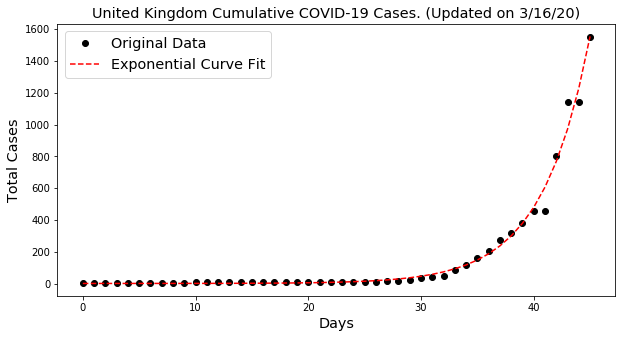



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 1414
	Confirmed cases on 3/9/20 	 321
	Ratio: 4.4
	Weekly increase: 340.5 %
	Daily increase: 23.6 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.994534097636
	Doubling Time (during middle of growth):  6.16 (± 2.23 ) days

** Based on Exponential Fit **

	R^2: 0.994391756456
	Doubling Time (represents overall growth):  3.46 (± 0.35 ) days


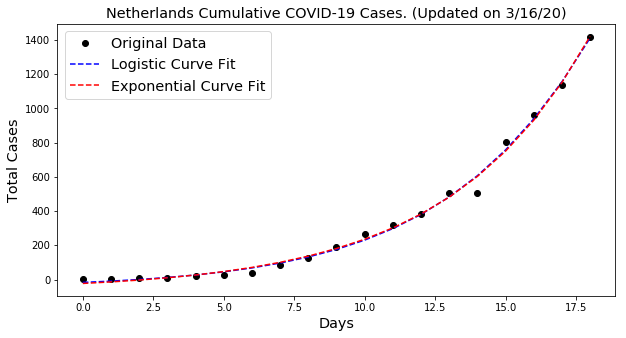



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 1333
	Confirmed cases on 3/9/20 	 205
	Ratio: 6.5
	Weekly increase: 550.2 %
	Daily increase: 30.7 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.996123224206
	Doubling Time (during middle of growth):  2.64 (± 0.39 ) days

** Based on Exponential Fit **

	R^2: 0.972283391334
	Doubling Time (represents overall growth):  3.83 (± 0.86 ) days


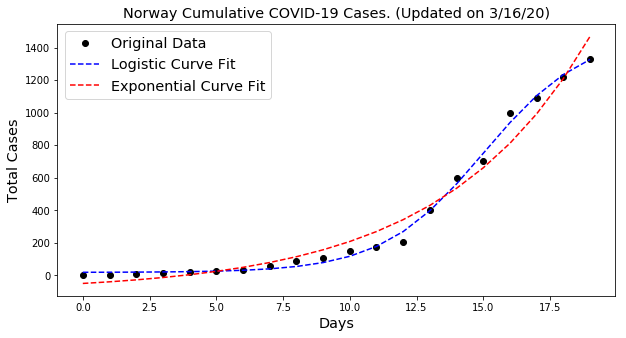



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 1103
	Confirmed cases on 3/9/20 	 248
	Ratio: 4.45
	Weekly increase: 344.8 %
	Daily increase: 23.8 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.977742590939
	Doubling Time (represents overall growth):  3.48 (± 0.33 ) days


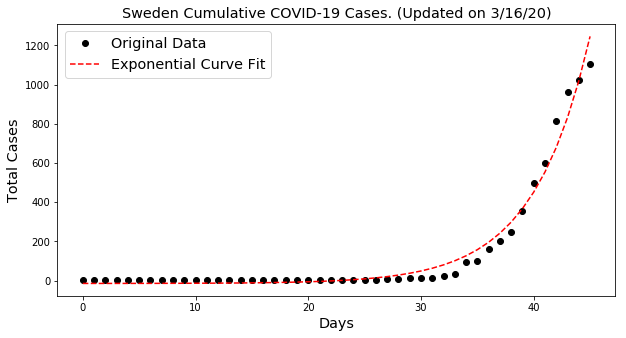



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 1058
	Confirmed cases on 3/9/20 	 239
	Ratio: 4.43
	Weekly increase: 342.7 %
	Daily increase: 23.7 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.990395182215
	Doubling Time (represents overall growth):  2.91 (± 0.19 ) days


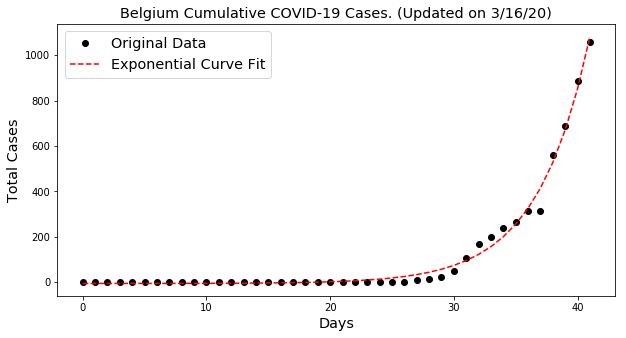



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 1018
	Confirmed cases on 3/9/20 	 131
	Ratio: 7.77
	Weekly increase: 677.1 %
	Daily increase: 34.0 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.997200696209
	Doubling Time (during middle of growth):  3.34 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.993438239578
	Doubling Time (represents overall growth):  2.54 (± 0.22 ) days


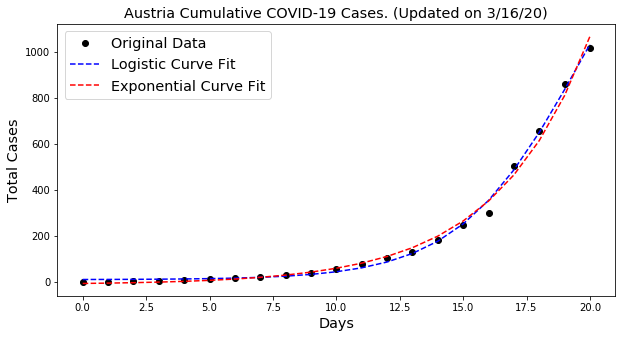



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 932
	Confirmed cases on 3/9/20 	 92
	Ratio: 10.13
	Weekly increase: 913.0 %
	Daily increase: 39.2 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.998329821032
	Doubling Time (during middle of growth):  1.5 (± 0.15 ) days


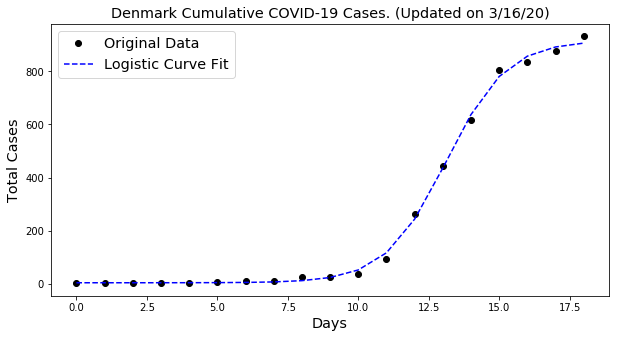



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 825
	Confirmed cases on 3/9/20 	 511
	Ratio: 1.61
	Weekly increase: 61.4 %
	Daily increase: 7.1 % per day
	Doubling Time (represents recent growth): 10.1 days

** Based on Logistic Fit**

	R^2: 0.997246362264
	Doubling Time (during middle of growth):  12.36 (± 1.18 ) days

** Based on Exponential Fit **

	R^2: 0.994777519938
	Doubling Time (represents overall growth):  8.95 (± 0.45 ) days


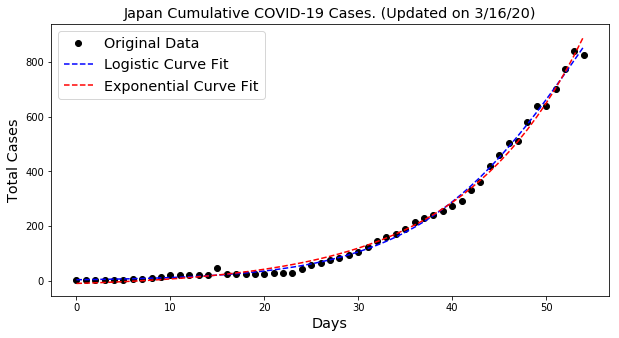



Cruise Ship

** Based on Logistic Fit**

	R^2: 0.995641347347
	Doubling Time (during middle of growth):  2.68 (± 0.29 ) days


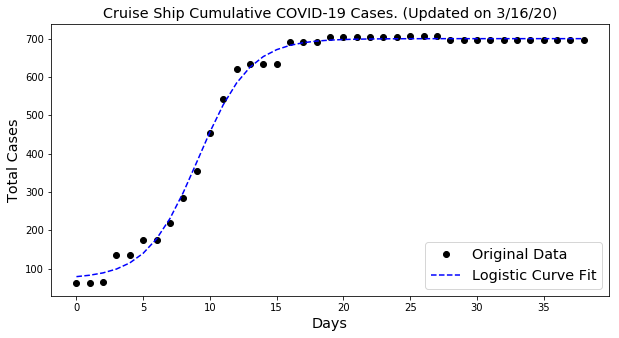



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 566
	Confirmed cases on 3/9/20 	 117
	Ratio: 4.84
	Weekly increase: 383.8 %
	Daily increase: 25.3 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.970627978046
	Doubling Time (represents overall growth):  2.36 (± 0.24 ) days


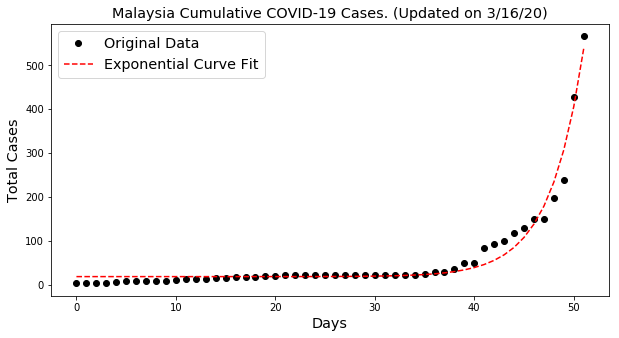



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 439
	Confirmed cases on 3/9/20 	 18
	Ratio: 24.39
	Weekly increase: 2338.9 %
	Daily increase: 57.8 % per day
	Doubling Time (represents recent growth): 1.5 days

** Based on Logistic Fit**

	R^2: 0.963281999025
	Doubling Time (during middle of growth):  1.29 (± 0.66 ) days


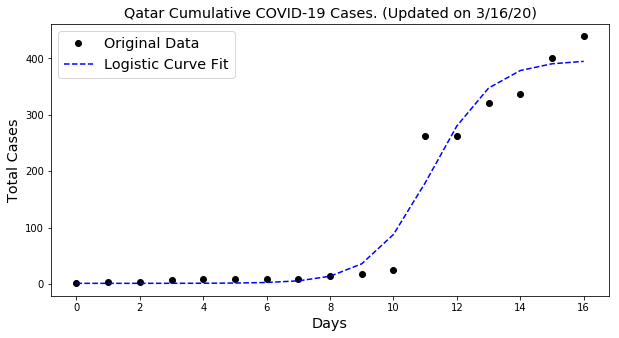



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 415
	Confirmed cases on 3/9/20 	 77
	Ratio: 5.39
	Weekly increase: 439.0 %
	Daily increase: 27.2 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.979515616725
	Doubling Time (represents overall growth):  2.61 (± 0.22 ) days


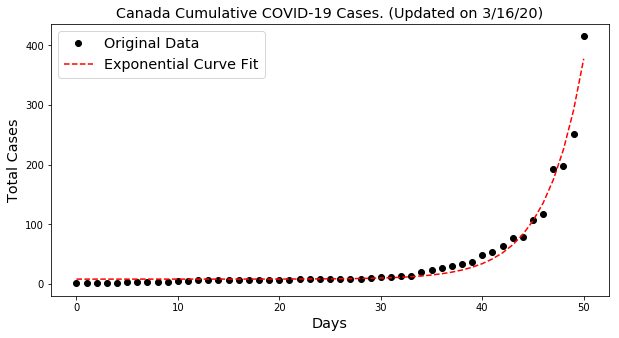



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 377
	Confirmed cases on 3/9/20 	 91
	Ratio: 4.14
	Weekly increase: 314.3 %
	Daily increase: 22.5 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.992950070816
	Doubling Time (represents overall growth):  3.1 (± 0.15 ) days


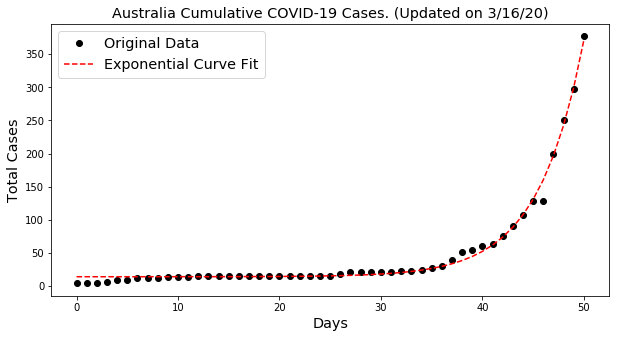



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 331
	Confirmed cases on 3/9/20 	 30
	Ratio: 11.03
	Weekly increase: 1003.3 %
	Daily increase: 40.9 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.994872834334
	Doubling Time (during middle of growth):  3.12 (± 0.95 ) days

** Based on Exponential Fit **

	R^2: 0.994370925281
	Doubling Time (represents overall growth):  1.89 (± 0.19 ) days


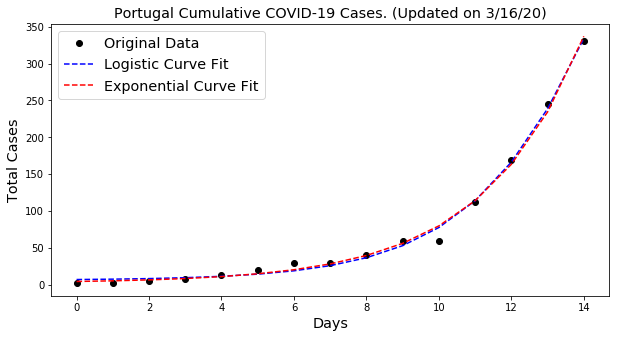



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 331
	Confirmed cases on 3/9/20 	 73
	Ratio: 4.53
	Weekly increase: 353.4 %
	Daily increase: 24.1 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.973397981759
	Doubling Time (during middle of growth):  4.91 (± 2.97 ) days

** Based on Exponential Fit **

	R^2: 0.972660231165
	Doubling Time (represents overall growth):  3.07 (± 0.61 ) days


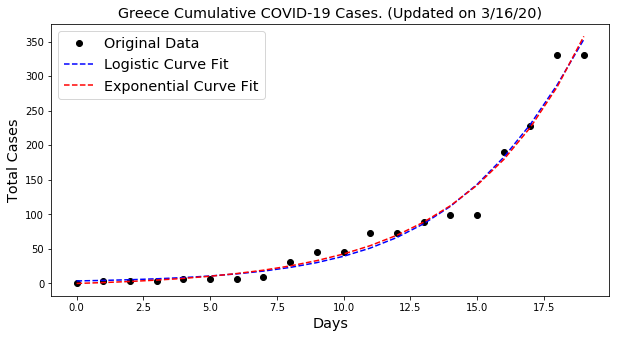



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 298
	Confirmed cases on 3/9/20 	 31
	Ratio: 9.61
	Weekly increase: 861.3 %
	Daily increase: 38.2 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.994884256328
	Doubling Time (during middle of growth):  3.2 (± 0.8 ) days

** Based on Exponential Fit **

	R^2: 0.990653106567
	Doubling Time (represents overall growth):  2.63 (± 0.36 ) days


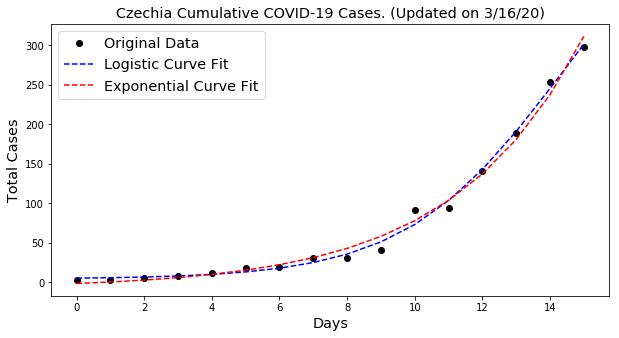



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 277
	Confirmed cases on 3/9/20 	 30
	Ratio: 9.23
	Weekly increase: 823.3 %
	Daily increase: 37.4 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Exponential Fit **

	R^2: 0.965298778751
	Doubling Time (represents overall growth):  2.41 (± 0.27 ) days


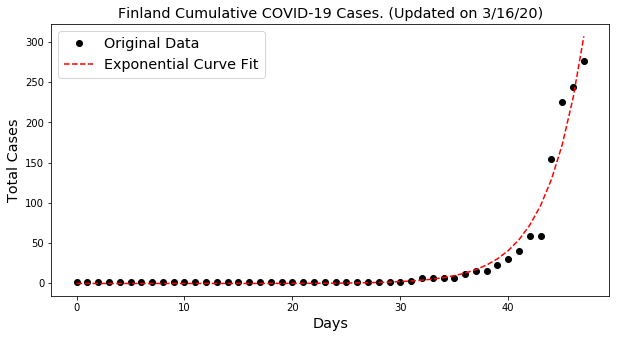



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 255
	Confirmed cases on 3/9/20 	 61
	Ratio: 4.18
	Weekly increase: 318.0 %
	Daily increase: 22.7 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.995064381958
	Doubling Time (during middle of growth):  4.72 (± 0.85 ) days

** Based on Exponential Fit **

	R^2: 0.990501774229
	Doubling Time (represents overall growth):  3.74 (± 0.38 ) days


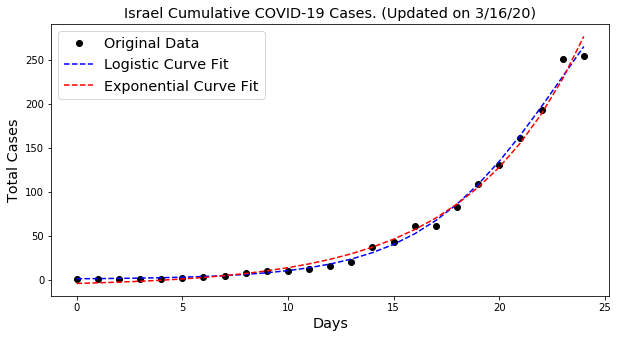



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 253
	Confirmed cases on 3/9/20 	 16
	Ratio: 15.81
	Weekly increase: 1481.2 %
	Daily increase: 48.3 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Logistic Fit**

	R^2: 0.99896122511
	Doubling Time (during middle of growth):  2.09 (± 0.24 ) days

** Based on Exponential Fit **

	R^2: 0.980366005746
	Doubling Time (represents overall growth):  3.3 (± 1.1 ) days


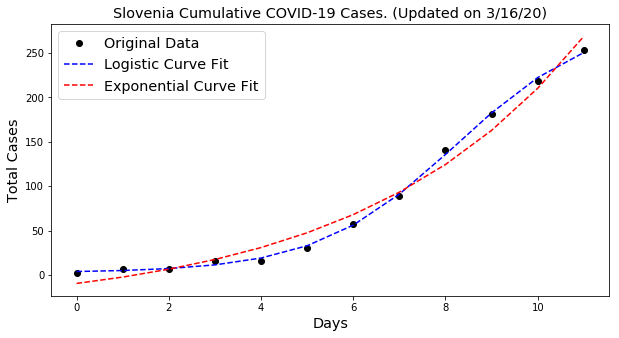



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 243
	Confirmed cases on 3/9/20 	 150
	Ratio: 1.62
	Weekly increase: 62.0 %
	Daily increase: 7.1 % per day
	Doubling Time (represents recent growth): 10.1 days

** Based on Logistic Fit**

	R^2: 0.970889461902
	Doubling Time (during middle of growth):  39.16 (± 8.85 ) days

** Based on Exponential Fit **

	R^2: 0.970889462472
	Doubling Time (represents overall growth):  19.58 (± 4.1 ) days


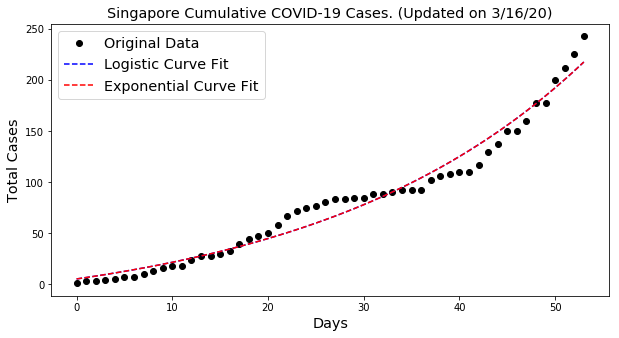



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 214
	Confirmed cases on 3/9/20 	 95
	Ratio: 2.25
	Weekly increase: 125.3 %
	Daily increase: 12.3 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.960242224334
	Doubling Time (during middle of growth):  2.79 (± 1.21 ) days


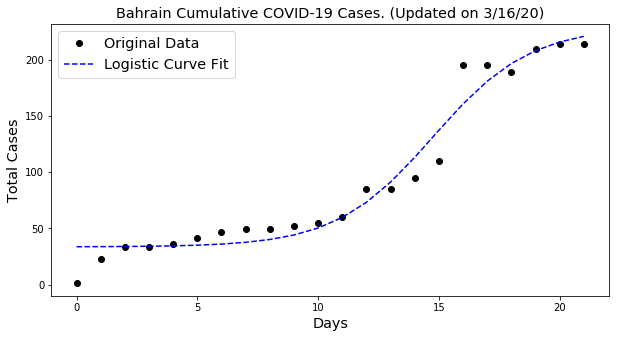



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 205
	Confirmed cases on 3/9/20 	 10
	Ratio: 20.5
	Weekly increase: 1950.0 %
	Daily increase: 54.0 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Exponential Fit **

	R^2: 0.966332450173
	Doubling Time (represents overall growth):  1.78 (± 0.36 ) days


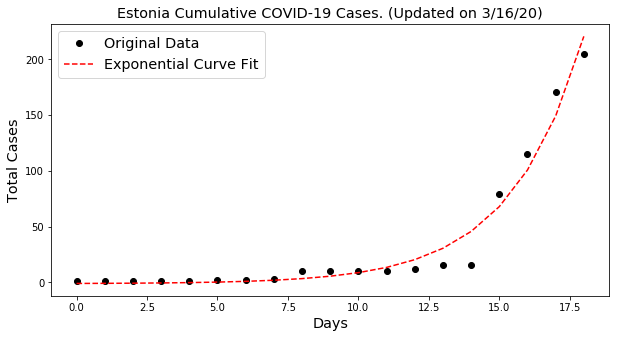



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 200
	Confirmed cases on 3/9/20 	 25
	Ratio: 8.0
	Weekly increase: 700.0 %
	Daily increase: 34.6 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.967663356272
	Doubling Time (during middle of growth):  1.53 (± 0.66 ) days


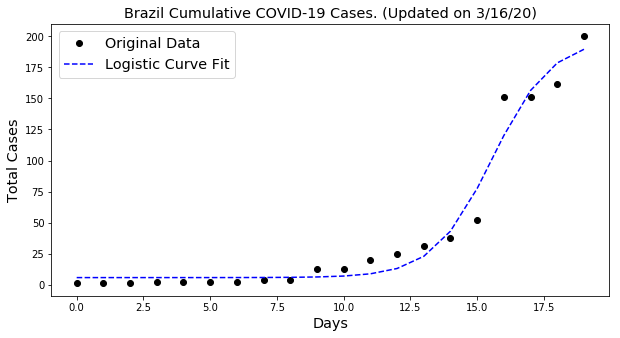



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 180
	Confirmed cases on 3/9/20 	 58
	Ratio: 3.1
	Weekly increase: 210.3 %
	Daily increase: 17.6 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.988320100415
	Doubling Time (during middle of growth):  7.35 (± 4.94 ) days

** Based on Exponential Fit **

	R^2: 0.987491789478
	Doubling Time (represents overall growth):  5.88 (± 1.36 ) days


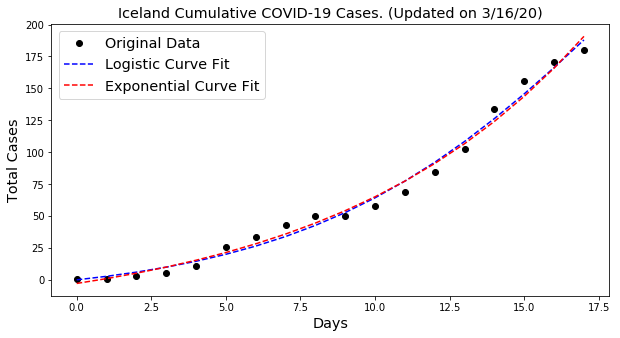



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 177
	Confirmed cases on 3/9/20 	 16
	Ratio: 11.06
	Weekly increase: 1006.2 %
	Daily increase: 41.0 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.994470815271
	Doubling Time (during middle of growth):  4.2 (± 2.06 ) days

** Based on Exponential Fit **

	R^2: 0.99440265481
	Doubling Time (represents overall growth):  2.29 (± 0.29 ) days


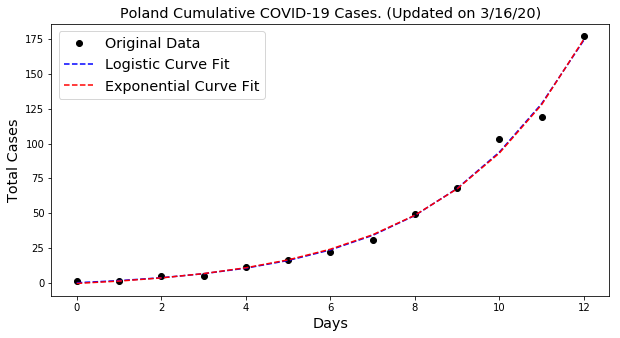



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 169
	Confirmed cases on 3/9/20 	 21
	Ratio: 8.05
	Weekly increase: 704.8 %
	Daily increase: 34.7 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.977385084547
	Doubling Time (during middle of growth):  3.01 (± 1.43 ) days

** Based on Exponential Fit **

	R^2: 0.97221785917
	Doubling Time (represents overall growth):  2.8 (± 0.64 ) days


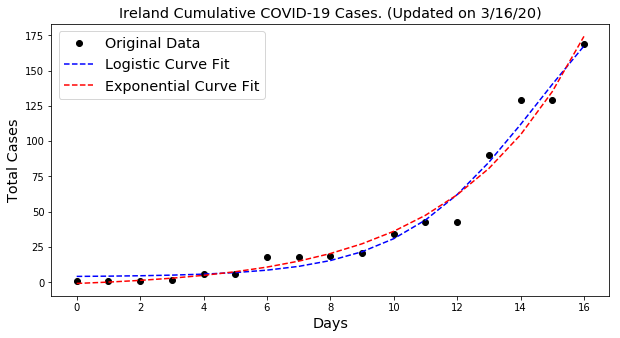



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 158
	Confirmed cases on 3/9/20 	 15
	Ratio: 10.53
	Weekly increase: 953.3 %
	Daily increase: 40.0 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.992429784751
	Doubling Time (during middle of growth):  2.3 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.974836829029
	Doubling Time (represents overall growth):  2.71 (± 0.5 ) days


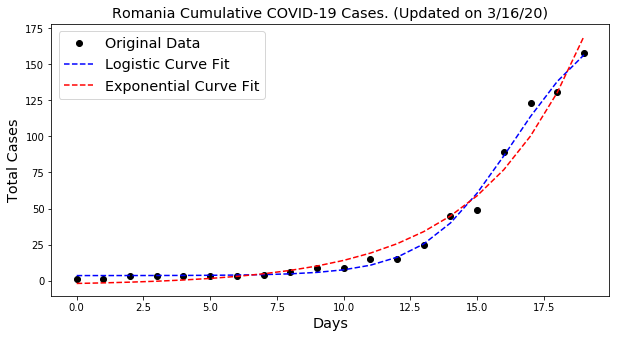



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 155
	Confirmed cases on 3/9/20 	 8
	Ratio: 19.38
	Weekly increase: 1837.5 %
	Daily increase: 52.7 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Logistic Fit**

	R^2: 0.97913643677
	Doubling Time (during middle of growth):  2.77 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.979136437857
	Doubling Time (represents overall growth):  1.38 (± 0.27 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


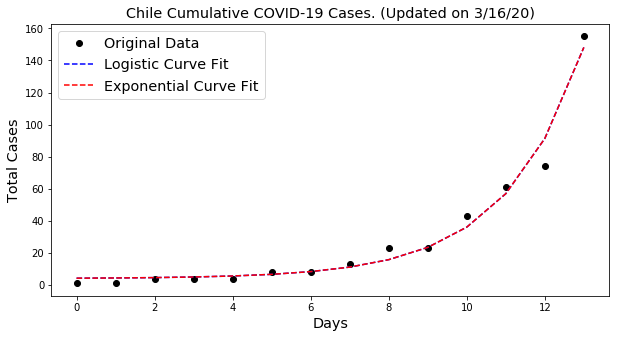



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 150
	Confirmed cases on 3/9/20 	 55
	Ratio: 2.73
	Weekly increase: 172.7 %
	Daily increase: 15.4 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.970528573541
	Doubling Time (during middle of growth):  5.22 (± 1.96 ) days

** Based on Exponential Fit **

	R^2: 0.9667082789
	Doubling Time (represents overall growth):  3.76 (± 0.58 ) days


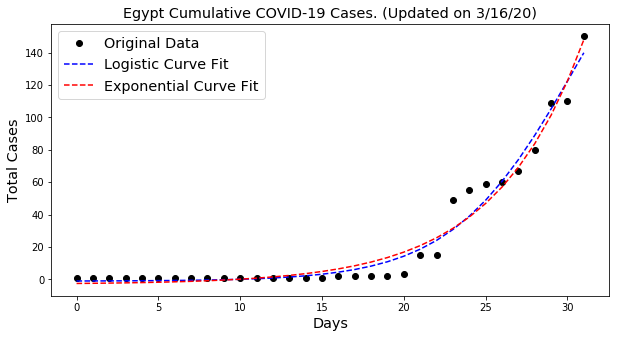



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 147
	Confirmed cases on 3/9/20 	 50
	Ratio: 2.94
	Weekly increase: 194.0 %
	Daily increase: 16.7 % per day
	Doubling Time (represents recent growth): 4.5 days


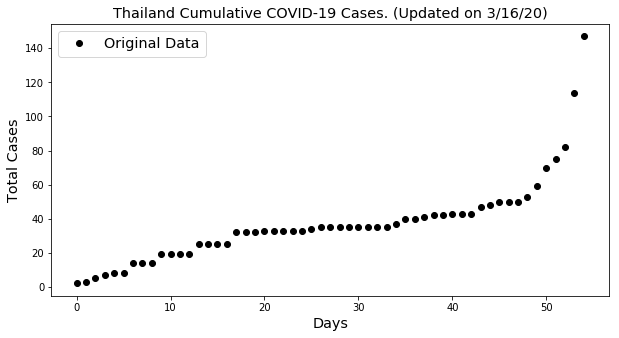



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 142
	Confirmed cases on 3/9/20 	 20
	Ratio: 7.1
	Weekly increase: 610.0 %
	Daily increase: 32.3 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Exponential Fit **

	R^2: 0.972617936233
	Doubling Time (represents overall growth):  2.53 (± 0.26 ) days


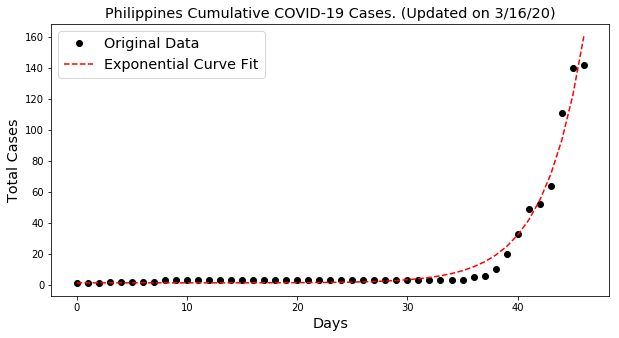



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 136
	Confirmed cases on 3/9/20 	 6
	Ratio: 22.67
	Weekly increase: 2166.7 %
	Daily increase: 56.2 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Exponential Fit **

	R^2: 0.969212641752
	Doubling Time (represents overall growth):  0.88 (± 0.17 ) days


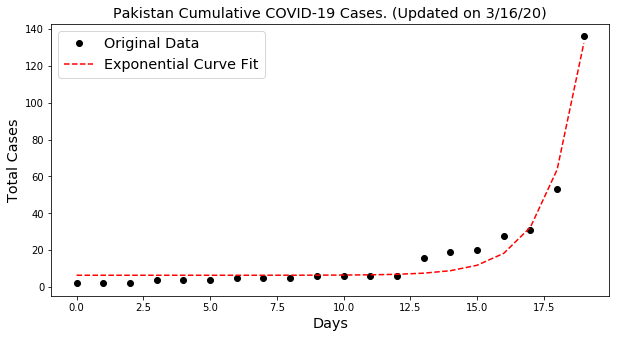



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 134
	Confirmed cases on 3/9/20 	 19
	Ratio: 7.05
	Weekly increase: 605.3 %
	Daily increase: 32.2 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.989535669978
	Doubling Time (during middle of growth):  2.56 (± 0.85 ) days

** Based on Exponential Fit **

	R^2: 0.978557935696
	Doubling Time (represents overall growth):  2.77 (± 0.64 ) days


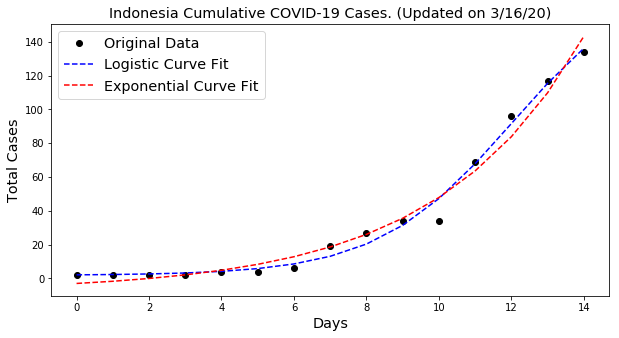



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 124
	Confirmed cases on 3/9/20 	 60
	Ratio: 2.07
	Weekly increase: 106.7 %
	Daily increase: 10.9 % per day
	Doubling Time (represents recent growth): 6.7 days

** Based on Logistic Fit**

	R^2: 0.98539414989
	Doubling Time (during middle of growth):  19.77 (± 18.35 ) days

** Based on Exponential Fit **

	R^2: 0.985394150354
	Doubling Time (represents overall growth):  9.88 (± 2.88 ) days


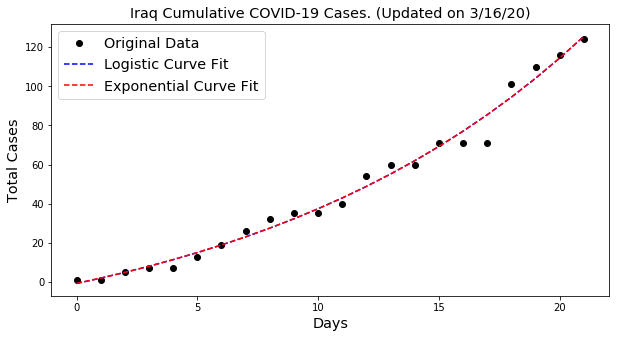



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 123
	Confirmed cases on 3/9/20 	 64
	Ratio: 1.92
	Weekly increase: 92.2 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days


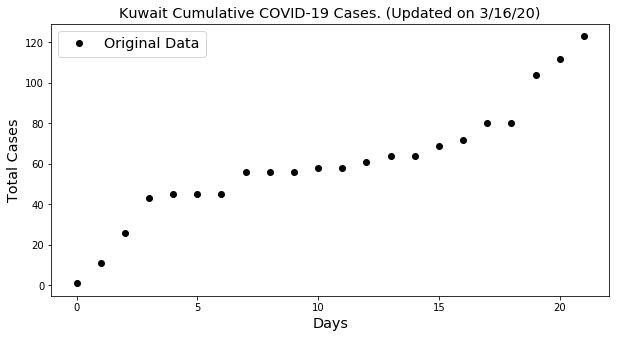



India

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 119
	Confirmed cases on 3/9/20 	 43
	Ratio: 2.77
	Weekly increase: 176.7 %
	Daily increase: 15.7 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Exponential Fit **

	R^2: 0.980375695453
	Doubling Time (represents overall growth):  4.43 (± 0.4 ) days


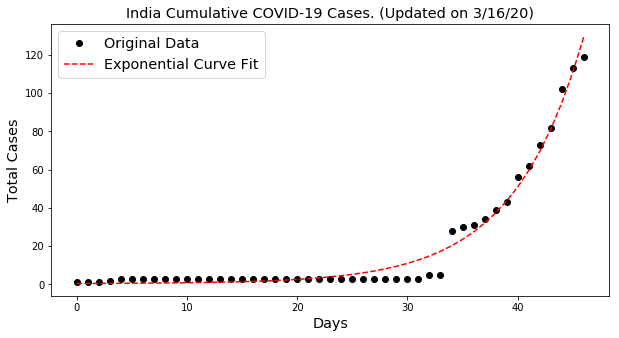



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 118
	Confirmed cases on 3/9/20 	 15
	Ratio: 7.87
	Weekly increase: 686.7 %
	Daily increase: 34.3 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.987126990879
	Doubling Time (during middle of growth):  1.23 (± 0.39 ) days


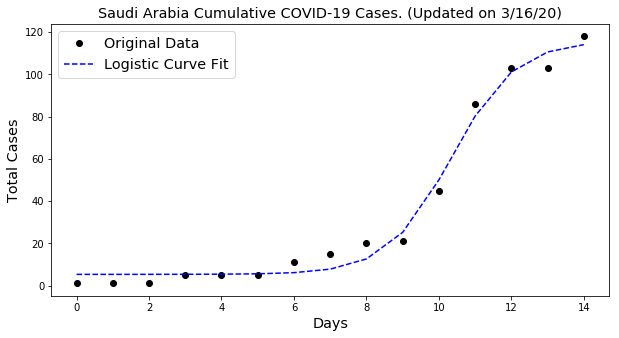



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 109
	Confirmed cases on 3/9/20 	 36
	Ratio: 3.03
	Weekly increase: 202.8 %
	Daily increase: 17.1 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Logistic Fit**

	R^2: 0.991667402645
	Doubling Time (during middle of growth):  6.56 (± 2.81 ) days

** Based on Exponential Fit **

	R^2: 0.989498122366
	Doubling Time (represents overall growth):  6.59 (± 1.42 ) days


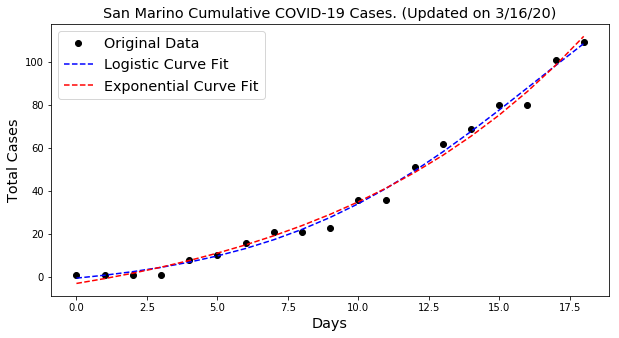

In [5]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


         Countries  Inferred Doubling Time  Recent Doubling Time
0            China                     6.5                2270.3
1            Italy                     3.9                   4.4
2             Iran                     6.3                   6.6
3            Spain                     2.4                   2.2
4     Korea, South                     4.1                  50.3
5          Germany                     2.6                   2.7
6           France                     3.1                   2.9
7               US                     2.6                   2.3
8      Switzerland                     2.7                   2.7
9   United Kingdom                     2.9                   3.1
10     Netherlands                     3.5                   3.3
11          

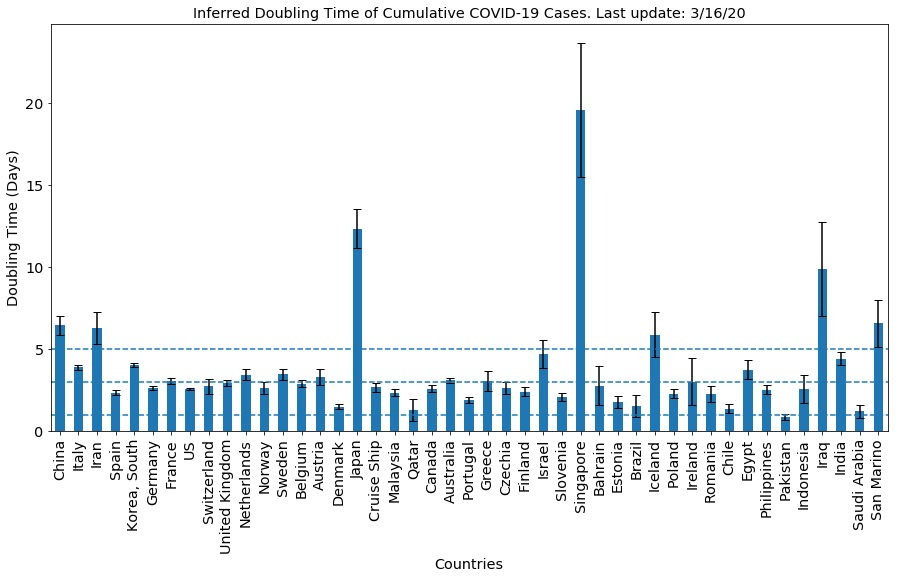

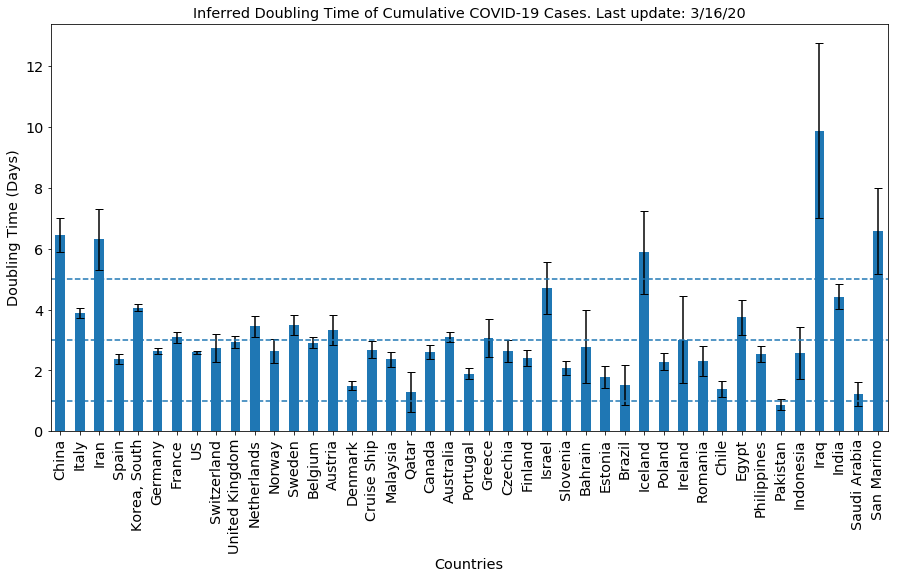

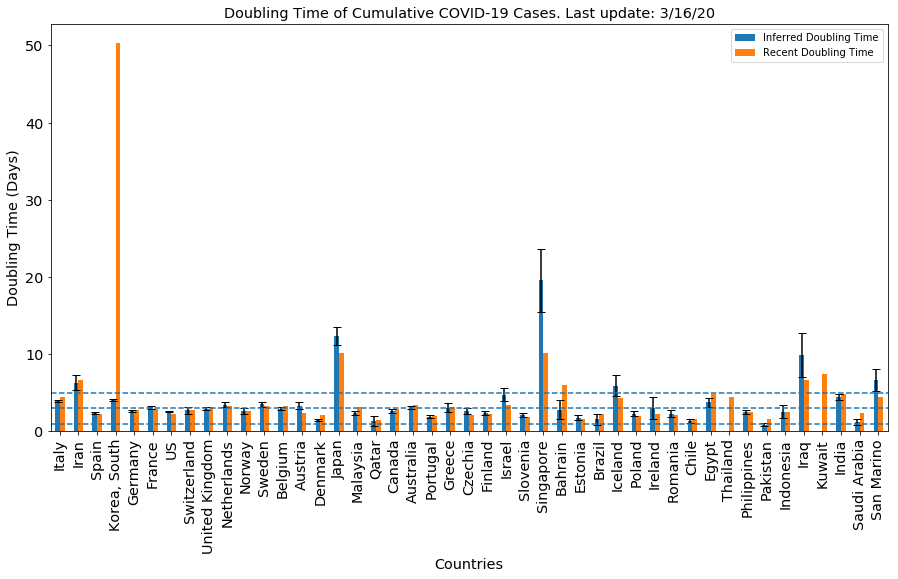

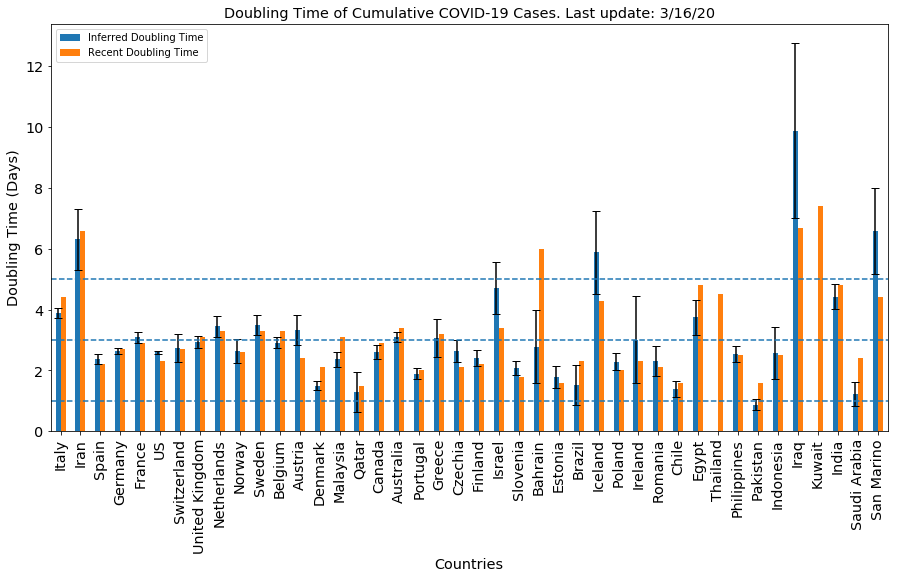

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [7]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    try:
        if ',' in location:
            result = [x.strip() for x in location.split(',')]
            statename = states[result[1]]
            row['State'] = statename
            uscases.loc[index, 'Province/State'] = statename
    except:
        print('Error parsing US state:', location)        
            
usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/16/20


,3/16/20
Province/State,
New York,967
Washington,904
California,557
Massachusetts,197
New Jersey,178
Colorado,160
Florida,155
Louisiana,136
Georgia,121


## Curve Fitting US COVID-19 Cases

                3/16/20
Province/State         
New York            967
Washington          904
California          557
Massachusetts       197
New Jersey          178
Colorado            160
Florida             155
Louisiana           136
Georgia             121
Illinois            105


US state:  New York

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 967
	Confirmed cases on 3/9/20 	 142
	Ratio: 6.81
	Weekly increase: 581.0 %
	Daily increase: 31.5 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.998332580129
	Doubling Time (during middle of growth):  5.17 (± 1.21 ) days

** Based on Exponential Fit **

	R^2: 0.998332580509
	Doubling Time (represents overall growth):  2.58 (± 0.16 ) days


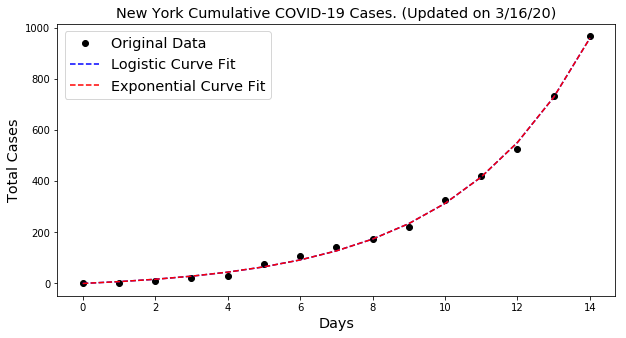



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 904
	Confirmed cases on 3/9/20 	 122
	Ratio: 7.41
	Weekly increase: 641.0 %
	Daily increase: 33.1 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Exponential Fit **

	R^2: 0.981533338678
	Doubling Time (represents overall growth):  3.23 (± 0.25 ) days


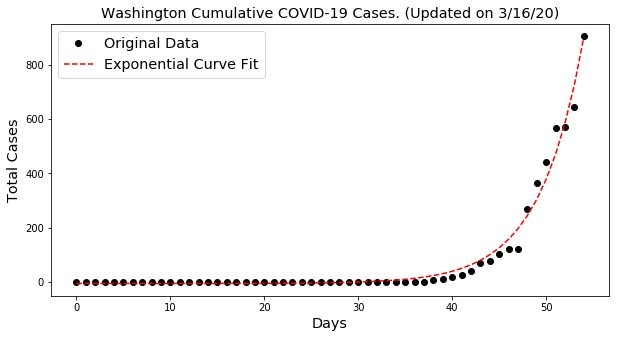



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 557
	Confirmed cases on 3/9/20 	 101
	Ratio: 5.51
	Weekly increase: 451.5 %
	Daily increase: 27.6 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.998682373017
	Doubling Time (represents overall growth):  2.97 (± 0.06 ) days


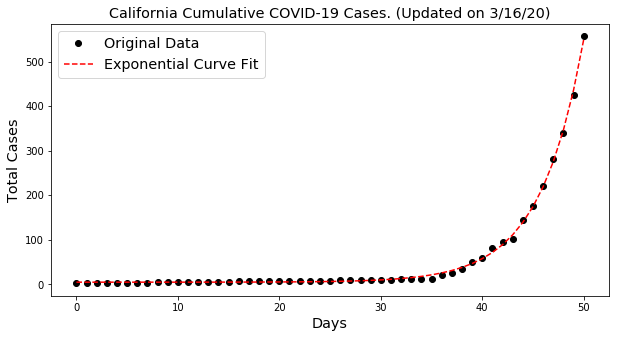



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 197
	Confirmed cases on 3/9/20 	 22
	Ratio: 8.95
	Weekly increase: 795.5 %
	Daily increase: 36.8 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Exponential Fit **

	R^2: 0.95402638063
	Doubling Time (represents overall growth):  3.24 (± 0.45 ) days


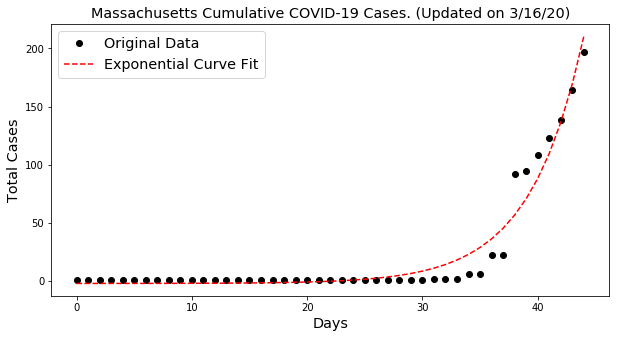



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 178
	Confirmed cases on 3/9/20 	 5
	Ratio: 35.6
	Weekly increase: 3460.0 %
	Daily increase: 66.6 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Logistic Fit**

	R^2: 0.990541879913
	Doubling Time (during middle of growth):  2.6 (± 0.58 ) days

** Based on Exponential Fit **

	R^2: 0.990541880177
	Doubling Time (represents overall growth):  1.3 (± 0.19 ) days


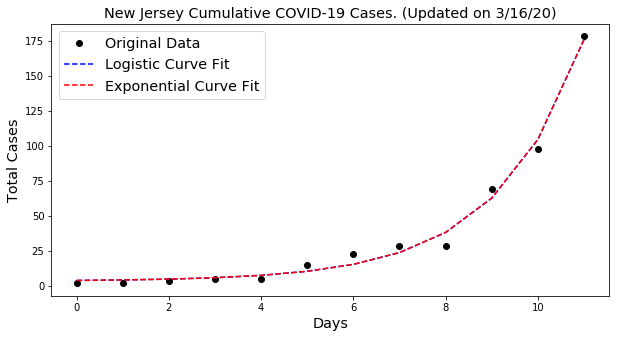



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 160
	Confirmed cases on 3/9/20 	 7
	Ratio: 22.86
	Weekly increase: 2185.7 %
	Daily increase: 56.4 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Logistic Fit**

	R^2: 0.987551784702
	Doubling Time (during middle of growth):  2.28 (± 1.15 ) days

** Based on Exponential Fit **

	R^2: 0.980353083354
	Doubling Time (represents overall growth):  2.38 (± 0.72 ) days


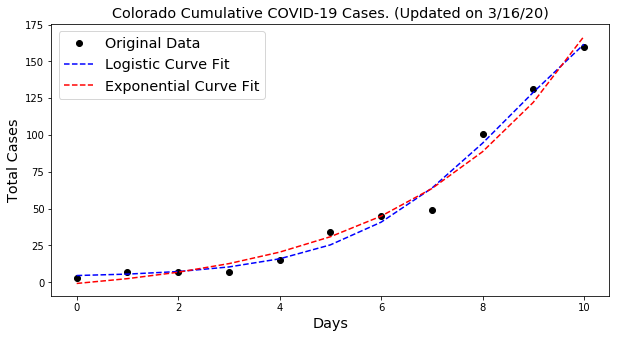



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 155
	Confirmed cases on 3/9/20 	 13
	Ratio: 11.92
	Weekly increase: 1092.3 %
	Daily increase: 42.5 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.998211014709
	Doubling Time (during middle of growth):  3.25 (± 0.6 ) days

** Based on Exponential Fit **

	R^2: 0.997796461744
	Doubling Time (represents overall growth):  1.91 (± 0.12 ) days


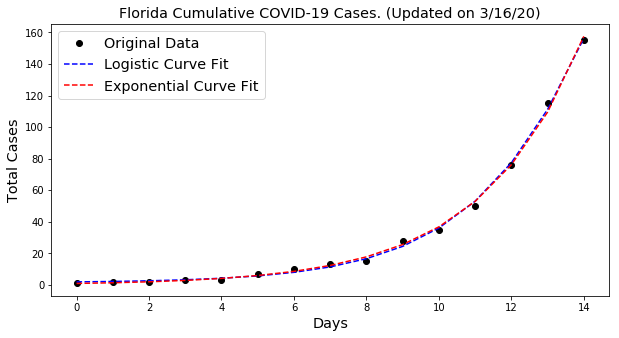



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 136
	Confirmed cases on 3/9/20 	 1
	Ratio: 136.0
	Weekly increase: 13500.0 %
	Daily increase: 101.7 % per day
	Doubling Time (represents recent growth): 1.0 days

** Based on Logistic Fit**

	R^2: 0.987305125579
	Doubling Time (during middle of growth):  2.12 (± 1.73 ) days

** Based on Exponential Fit **

	R^2: 0.982945083378
	Doubling Time (represents overall growth):  2.27 (± 0.99 ) days


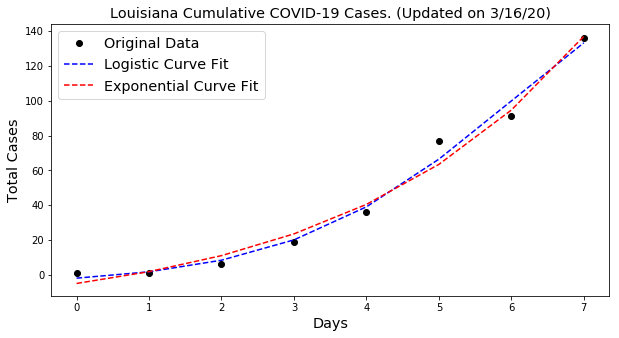



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 121
	Confirmed cases on 3/9/20 	 10
	Ratio: 12.1
	Weekly increase: 1110.0 %
	Daily increase: 42.8 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Logistic Fit**

	R^2: 0.99603574296
	Doubling Time (during middle of growth):  2.8 (± 0.71 ) days

** Based on Exponential Fit **

	R^2: 0.993018782226
	Doubling Time (represents overall growth):  2.13 (± 0.27 ) days


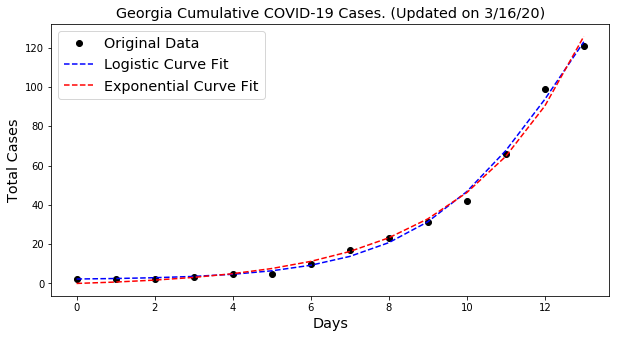



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 3/16/20 	 105
	Confirmed cases on 3/9/20 	 7
	Ratio: 15.0
	Weekly increase: 1400.0 %
	Daily increase: 47.2 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Exponential Fit **

	R^2: 0.987599332187
	Doubling Time (represents overall growth):  2.18 (± 0.14 ) days


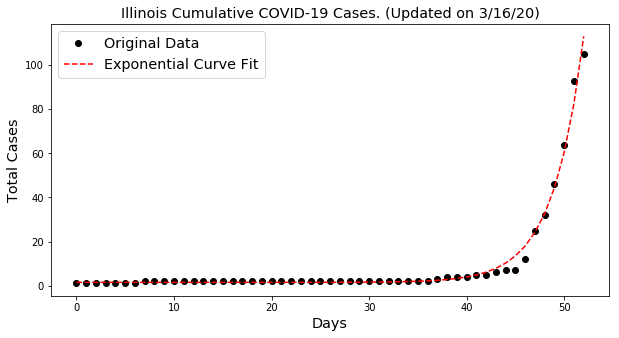

In [8]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


          States  Inferred Doubling Time  Recent Doubling Time
0       New York                     2.6                   2.5
1     Washington                     3.2                   2.4
2     California                     3.0                   2.8
3  Massachusetts                     3.2                   2.2
4     New Jersey                     1.3                   1.4
5       Colorado                     2.3                   1.6
6        Florida                     1.9                   2.0
7      Louisiana                     2.1                   1.0
8        Georgia                     2.8                   1.9
9       Illinois                     2.2                   1.8




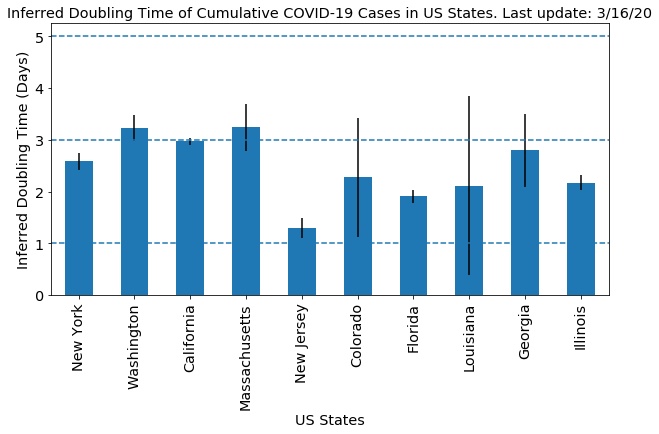

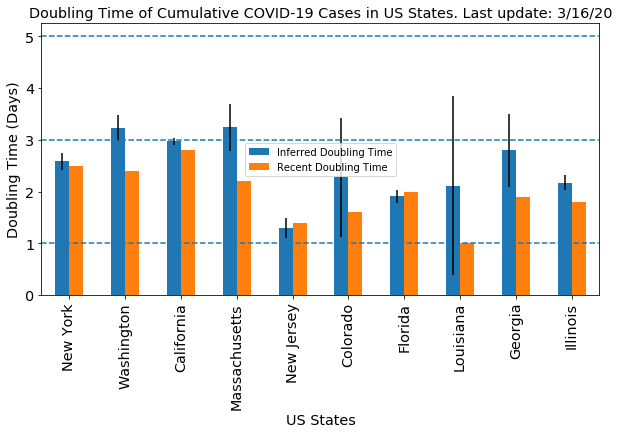

In [9]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()